In [67]:
import pandas as pd
import numpy as np

# read emoticon dataset
train_emoticon_df = pd.read_csv("datasets/train/train_emoticon.csv")
train_emoticon_X = train_emoticon_df['input_emoticon'].tolist()
train_emoticon_Y = train_emoticon_df['label'].tolist()

test_emoticon_X = pd.read_csv("datasets/test/test_emoticon.csv")['input_emoticon'].tolist()


# read text sequence dataset
train_seq_df = pd.read_csv("datasets/train/train_text_seq.csv")
train_seq_X = train_seq_df['input_str'].tolist()
train_seq_Y = train_seq_df['label'].tolist()

test_seq_X = pd.read_csv("datasets/test/test_text_seq.csv")['input_str'].tolist()



# read feature dataset
train_feat = np.load("datasets/train/train_feature.npz", allow_pickle=True)
train_feat_X = train_feat['features']
train_feat_Y = train_feat['label']

test_feat_X = np.load("datasets/test/test_feature.npz", allow_pickle=True)['features']

# Read validation emoticon dataset
valid_emoticon_df = pd.read_csv("datasets/valid/valid_emoticon.csv")
valid_emoticon_X = valid_emoticon_df['input_emoticon'].tolist()
valid_emoticon_Y = valid_emoticon_df['label'].tolist()

# Read validation text sequence dataset
valid_seq_df = pd.read_csv("datasets/valid/valid_text_seq.csv")
valid_seq_X = valid_seq_df['input_str'].tolist()
valid_seq_Y = valid_seq_df['label'].tolist()

# Read validation feature dataset
valid_feat = np.load("datasets/valid/valid_feature.npz", allow_pickle=True)
valid_feat_X = valid_feat['features']
valid_feat_Y = valid_feat['label']


In [46]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assuming train_feat_X and valid_feat_X are defined
n_components = 60  # Number of components you want to preserve
scaler = StandardScaler()
pca = PCA(n_components=n_components)

# Reshape the training data to (7080 * 13, 768)
train_feat_X_reshaped = train_feat_X.reshape(-1, 768)  # Shape will be (7080*13, 768)

# Standardize the reshaped training data
train_feat_X_scaled = scaler.fit_transform(train_feat_X_reshaped)

# Apply PCA
train_X_pca = pca.fit_transform(train_feat_X_scaled)

# Reshape back to (7080, 13, 50)
X_pca = train_X_pca.reshape(7080, 13, n_components)

# Now handle the validation data similarly
valid_feat_X_reshaped = valid_feat_X.reshape(-1, 768)  # Shape will be (len(valid_feat_X)*13, 768)
valid_feat_X_scaled = scaler.transform(valid_feat_X_reshaped)

# Apply PCA on the validation data
valid_X_pca = pca.transform(valid_feat_X_scaled)

# Reshape back to (len(valid_feat_X), 13, 50)
valid_X_pca = valid_X_pca.reshape(len(valid_feat_X), 13, n_components)

# Now X_pca and valid_X_pca contain the PCA-reduced data
print("Transformed Training Data Shape:", X_pca.shape)  # Should be (7080, 13, 50)
print("Transformed Validation Data Shape:", valid_X_pca.shape)  # Should be (len(valid_feat_X), 13, 50)




Transformed Training Data Shape: (7080, 13, 60)
Transformed Validation Data Shape: (489, 13, 60)


In [68]:
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler


# scaler = StandardScaler()
# pca = PCA(n_components= 50)

# X_train_feat = train_feat_X.reshape(train_feat_X.shape[0], -1)
# X_train_feat_scaled = scaler.fit_transform(X_train_feat)
# X_train_feat = pca.fit_transform(X_train_feat_scaled)


In [69]:
ds2 = X_pca.reshape(X_pca.shape[0], -1)
valid_ds2 = valid_X_pca.reshape(valid_X_pca.shape[0], -1)

In [70]:
from sklearn.preprocessing import LabelEncoder

In [71]:
train_emo_X = train_emoticon_df['input_emoticon'].tolist()
train_emo_X = np.array([[ord(x) for x in e] for e in train_emo_X])
train_emo_Y = train_emoticon_df['label'].tolist()

valid_emo_X = valid_emoticon_df['input_emoticon'].tolist()
valid_emo_X = np.array([[ord(x)  for x in e] for e in valid_emo_X])
valid_emo_Y = valid_emoticon_df['label'].tolist()

emoji_encoder = LabelEncoder()

# Flatten the list of emojis and fit the label encoder
# Since train_emo_X is 2D (13, 786), we need to flatten it for unique emojis
flat_train_emojis = [emoji for sublist in train_emo_X for emoji in sublist]
emoji_encoder.fit(flat_train_emojis)

# Transform the training emojis to their corresponding numerical labels
train_emo_X_encoded = np.array([[emoji_encoder.transform([x])[0] for x in e] for e in train_emo_X])

# Transform the validation emojis using the same encoder
valid_emo_X_encoded = np.array([[emoji_encoder.transform([x])[0] for x in e] for e in valid_emo_X])

In [72]:
X_train_seq = np.array([[int(char) for char in sequence] for sequence in train_seq_X])
X_valid_seq = np.array([[int(char) for char in sequence] for sequence in valid_seq_X])


In [73]:
X_train_final = np.concatenate((np.array(train_emo_X_encoded), ds2 , np.array(X_train_seq)), axis=1)
X_valid_final = np.concatenate((np.array(valid_emo_X_encoded), valid_ds2 , np.array(X_valid_seq)), axis=1)

In [74]:
X_train_final.shape

(7080, 843)

In [75]:
from sklearn.pipeline import make_pipeline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

In [76]:
model =make_pipeline(StandardScaler(), LogisticRegression(max_iter=200))

model.fit(X_train_final, train_seq_Y)

print(model.score(X_valid_final, valid_seq_Y))

0.9713701431492843


In [99]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

def build_logmodel():
    model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=200))
    return model

def evaluate_model(X_final, Y_final, X_valid_final, Y_valid_final):
    sizes = [0.2, 0.4, 0.6, 0.8, 1]
    train_accuracy = []
    valid_accuracy = []
    n_samples = X_final.shape[0]
    
    for size in sizes:
        print(f"Evaluating for training size fraction: {size}")
        
        # Create random subsets of training data using numpy indexing
        subset_size = int(n_samples * size)
        indices = np.random.choice(n_samples, subset_size, replace=False)
        
        
        # Index the train_X and train_Y arrays
        train_X = X_final[indices, :]  # Correct shape for feature matrix (2D array)
        train_Y = Y_final[indices]     # 1D array for labels
        
        # Train the model on the subset of data
        model_copy = build_logmodel()
        model_copy.fit(train_X, train_Y)
        
        # Compute training and validation accuracy
        train_accuracy.append(accuracy_score(train_Y, model_copy.predict(train_X)))
        valid_accuracy.append(accuracy_score(Y_valid_final, model_copy.predict(X_valid_final)))
    
    # Plot training vs validation accuracy
    plt.plot(sizes, train_accuracy, label='Training accuracy', marker='o')
    plt.plot(sizes, valid_accuracy, label='Validation accuracy', marker='x')
    plt.xlabel('Training data fraction')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.show()


Evaluating for training size fraction: 0.2
Evaluating for training size fraction: 0.4
Evaluating for training size fraction: 0.6
Evaluating for training size fraction: 0.8
Evaluating for training size fraction: 1


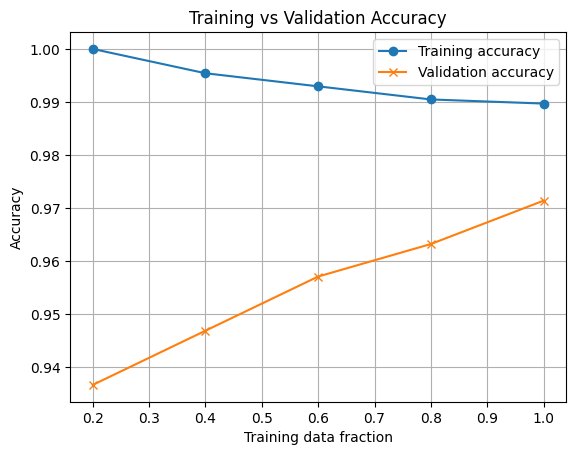

In [108]:
evaluate_model(X_train_final , np.array(train_seq_Y), X_valid_final , valid_seq_Y)